# Clean up nn.ipynb code

## Reader class

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD
from keras.optimizers import Adam
%matplotlib inline
import time

class Reader:
    """
    Class that serves to read arff file(s) in the format given in the WISDM dataset.
    Returns the data in a labelled pandas dataframe form.
    """
    
    def __init__(self, path, mode='f'):
        """
        Upon instantiating the class, all methods will be run in the correct order and the dataframe
        will be stored in the df attribute.
        If mode='f', the reader will read a single arff file given a file path.
        If mode='d', the reader will read all of the arff files in the given directory path.
        """
        self.df = self.wrapper(path,mode)
    
    def readarff(self, filename,collect=True): #collect if you need to collect attribute names
        """
        This method reads an arff file line-by-line and puts that file's data into a dataframe, and returns
        that dataframe. 
        If collect=True, it will also collect column ("attribute") names and return those as well.
        """
        with open(filename) as f:
            content = f.read().splitlines()
        data = False
        metalist = [] # storets metadata as list of rows
        datalist = [] # store data as list of rows
        
        # read data line-by-line
        for line in content:
            if data == True:
                line = line.split(",")
                datalist.append(line)
            elif line == "@data":
                data = True # read lines before "@data" as metadata and after as data
            else:
              # clean up metadata header
              if collect:
                line = line.replace(' "', ".")
                line = line.replace('" ', ".")
                line = line.replace(" ","")
                line = line.split(".")
                if len(line)==3: #ignore first two lines of file
                    line = line[1:3] #remove repetitive "@attribute"
                    metalist.append(line)
        
        # create dataframes from lists of rows
        if not collect:
            dataframe = pd.DataFrame(datalist,dtype=float)
            return dataframe
        else:
            dataframe = pd.DataFrame(datalist,dtype=float)
            metaframe = pd.DataFrame(metalist,columns=["attribute","description"])
            attributes = metaframe["attribute"].rename("SAMPLE")
            return dataframe, attributes
    
    def readdirectory(self, path,quiet=False): # make sure path ends in a slash
        """
        Given a directory path, this method will call readarff() on all arff files in that directory.
        It will then combine the data from all of those files into one dataframe, and return that dataframe.
        """
        alldata = []
        count = 0
        for filename in os.listdir(path):
            if filename.endswith(".arff"):
                if count == 0: #only collect attributes once
                    if not quiet:
                          print("processing "+filename+"; collecting attribute names")
                    dataframe, attributes = self.readarff(path+filename)
                    alldata.append(dataframe)
                else:
                    if not quiet:
                        print("processing "+filename)
                    dataframe = self.readarff(path+filename,collect=False)
                    alldata.append(dataframe)
                count += 1
                continue
            else:
                continue
        if not quiet:
            print("Concatenating data")
        alldata = pd.concat(alldata).reset_index(drop=True) #reset indices so it is continuous
        alldata.columns = attributes #assign column names
        return alldata
    
    def wrapper(self, path, mode='f'):
        """ 
        This method decides whether to call readarff() or readdirectory() based on the value of 'mode'.
        It also handles any errors that occur.
        """
        if mode == 'f':
            try:
                df =  self.readarff(path, collect = True)
                return df
            except:
                print("make sure you inputted the correct arff FILE path")
        elif mode == 'd':
            try:
                df =  self.readdirectory(path, quiet=True)
                return df
            except:
                print("make sure you inputted the correct arff DIRECTORY path, ending with a slash")
        else:
            print("mode must either be 'f' or 'd'")
            return 0

## Model class

In [2]:
class Model():
    
    def __init__(self, df):
        """
        Accepts inputs and runs necessary methods to initiate the model.
        Model contains the following attributes:
        .df = pandas dataframe of attribute data
        .X = independent data
        .Y = dependent data, one hot encoded
        .X_test, .X_train = split independent data
        .Y_test, .Y_train = split dependent data
        .model = Keras model format, outlining the layers of the model. To be used with KerasClassifier.
        .estimator = Instance of KerasClassifier using .model, 500 epochs, 200 batch size
        .results = List of k accuracy results from k-fold validation, if applicable
        .history = estimator.fit() history from train/test validation, if applicable
        .kfold = boolean for whether or not kfold is used, as opposed to a single train/test split
        .final = True when the final model has been calculated
        """
        self.df = df
    
    def preprocess(self, attributes, class_label, testsize):
        """
        attributes = list of desired attribute names
        class_label = string of the desired class label
        """
        # define self.X
        X = self.df[attributes]
        self.X = np.array(X)
        
        # define self.Y
        Y = self.df[class_label]
        self.encoder = LabelEncoder() # encoder stores conversion between class values (str) and identifiers (int)
        self. encoder.fit(Y)
        Y = self.encoder.transform(Y)
        self.Y = pd.get_dummies(Y) # convert to one hot encoded form
        
        # split into train and test sets
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size = testsize, stratify=self.Y, random_state=1)
    
    def baseline_model(self):
        """
        Defines Keras model.
        """
        model = Sequential()
        
        # define hyperparameter values
        p_input = 0 # fraction of the inputs to dropout
        p_hidden = 0.1 # fraction of the hidden layer nodes to dropout
        
        # input layer with dim = number of input attributes. Dropout applied.
        model.add(Dense(self.X.shape[1], input_dim=self.X.shape[1], activation='relu'))
        model.add(Dropout(p_input))
        
        # hidden layers with dim = 256, 128, and 64 (arbitrary). Each layer has dropout applied.
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to first hidden layer
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to second hidden layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(p_hidden)) # dropout applied to third hidden layer.
        
        # output layer with dim = number of output classes, using softmax activation.
        model.add(Dense(self.Y.shape[1], activation = 'softmax'))

        # compile model with categorical_crossentropy loss and adam optimizer.
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', 
                                                    keras.metrics.Precision(name="precision"),
                                                    keras.metrics.Recall(name="recall")])
        self.model = model
        return model
    
    def train(self, kfold=True):
        """ 
        Method to train the model and analyze results.
        TODO: save model attributes somehow so that 
        """
        self.final = False
        self.kfold = kfold
        start_time = time.time()
        self.estimator = KerasClassifier(build_fn=self.baseline_model, epochs=500, batch_size=200, verbose=0)
        
        if kfold:
            # run k-fold validation, which is slow
            # TODO use kfold.split() to get seperate test/train sets, then you can run estimator.fit()
            # on those in the same way we use it below. That would allow us to plot history.
            # Example: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
            print("Using K-fold validation method to train model and calculate score")
            kfold = KFold(n_splits=4, shuffle=True)
            results = cross_val_score(self.estimator, self.X, self.Y, cv=kfold)
            print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
            print("%s seconds" % (time.time() - start_time))
            self.results = results
        
        else:
            # run train/test split, which is fast
            print("Using training data to train model and testing data to calculate score")
            self.history = self.estimator.fit(self.X_train, self.Y_train, verbose = 0)
            self.plot_history(self.history)
            print("Test score: "+str(self.estimator.score(self.X_test, self.Y_test)))
            print("%s seconds" % (time.time() - start_time))
    
    def finaltrain(self):
        print("Using all data to train model")
        self.final = True
        self.kfold = False
        self.estimator = KerasClassifier(build_fn=self.baseline_model, epochs=500, batch_size=200, verbose=0)
        self.history = self.estimator.fit(self.X, self.Y, verbose = 0)
        self.plot_history(self.history)
        print("Model finished. Access the model with the .estimator attribute.")
        
    def evaluate(self):
        """
        Method to look at accuracies on a class-basis using model created during train() and 
        accuracies collected from using test data.
        TODO: Make this work for finaltrain, where there is no kfold
        """
        if not self.kfold:
            classes = {"A":"Walking","B":"Jogging","C":"Stairs","D":"Sitting",
               "E":"Standing","F":"Typing","G":"Brushing teeth","H":"Eating soup",
               "I":"Eating chips","J":"Eating pasta","K":"Drinking from a cup",
               "L":"Eating sandwich","M":"Kicking (soccer ball)","O":"Playing catch (with tennis ball)",
               "P":"Dribbling (basketball)", "Q":"Writing","R":"Clapping","S":"Folding clothes"}
            
            if self.final: # if evaluating the final model trained with finaltrain(), evaluate with all of the data
                print("Model prediction accuracies, using all data:")
                print("="*61)
                for i in self.encoder.classes_: # iterate through classes (string letters)
                    j = self.encoder.transform([i])[0] # use indexer because .transform returns a list instead of an integer ex: [1] instead of 1
                    idx = self.Y[j] # create reference array to only choose samples from the i'th (aka j'th) class
                    X1 = self.X[idx==1]
                    Y1 = self.Y[idx==1]
                    print(classes[i], "score:","-"*(40-len(classes[i])),str(self.estimator.score(X1, Y1)))
            else: # if evaluating an intermediate model trained with train(), evaluate with testing and training data seperately
                print("Model prediction accuracies, using test set of data:")
                print("="*61)
                for i in self.encoder.classes_: # iterate through classes (string letters)
                    j = self.encoder.transform([i])[0] # use indexer because .transform returns a list instead of an integer ex: [1] instead of 1
                    idx = self.Y_test[j] # create reference array to only choose samples from the i'th (aka j'th) class
                    X1 = self.X_test[idx==1]
                    Y1 = self.Y_test[idx==1]
                    print(classes[i], "score:","-"*(40-len(classes[i])),str(self.estimator.score(X1, Y1)))
                print("Model prediction accuracies, using train set of data:")
                print("="*61)
                for i in self.encoder.classes_: # iterate through classes (string letters)
                    j = self.encoder.transform([i])[0] # use indexer because .transform returns a list instead of an integer ex: [1] instead of 1
                    idx = self.Y_train[j] # create reference array to only choose samples from the i'th (aka j'th) class
                    X1 = self.X_train[idx==1]
                    Y1 = self.Y_train[idx==1]
                    print(classes[i], "score:","-"*(40-len(classes[i])),str(self.estimator.score(X1, Y1)))
        else:
            print("Model evaluation is not supported for kfold-trained data. Try using .train(kfold=False) first.")
            
    def plot_history(self, history):
        """ 
        Method copied from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
        Displays evolution of loss and accuracy during training, given the history
        """
        loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
        val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
        acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
        val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

        epochs = range(1,len(history.history[loss_list[0]]) + 1) # x values on graph

        ## Loss
        plt.figure(1)
        for l in loss_list:
            plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
        for l in val_loss_list:
            plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        ## Accuracy
        plt.figure(2)
        for l in acc_list:
            plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
        for l in val_acc_list:    
            plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

## Example using phone_accel data

### Apply the Reader class:

In [3]:
df = Reader("phone_accel/",mode='d').df # read entire directory into dataframe

### Apply the Model class:
#### Evaluate model with 70/30 train/test split

Using training data to train model and testing data to calculate score


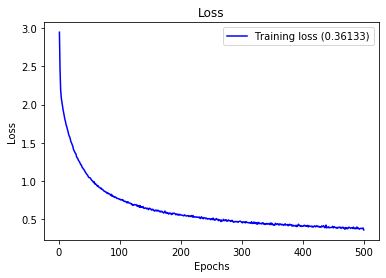

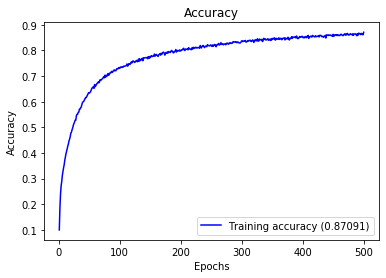

Test score: 0.8117867708206177
136.34487509727478 seconds
Model prediction accuracies, using test set of data:
Walking score: --------------------------------- 0.9501312375068665
Jogging score: --------------------------------- 0.9441624283790588
Stairs score: ---------------------------------- 0.8644067645072937
Sitting score: --------------------------------- 0.8021107912063599
Standing score: -------------------------------- 0.86753249168396
Typing score: ---------------------------------- 0.8446327447891235
Brushing teeth score: -------------------------- 0.8363636136054993
Eating soup score: ----------------------------- 0.688829779624939
Eating chips score: ---------------------------- 0.6415094137191772
Eating pasta score: ---------------------------- 0.709039568901062
Drinking from a cup score: --------------------- 0.7175572514533997
Eating sandwich score: ------------------------- 0.7640750408172607
Kicking (soccer ball) score: ------------------- 0.8613636493682861
Playing c

In [4]:
# list attributes and label of choice
attributes = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']
label = 'ACTIVITY'
testsize = 0.3 # use a 70/30 train/test split

# initiate and run model
model = Model(df)
model.preprocess(attributes, label, testsize)
model.train(kfold=False) # Use train/test split for training instead of kfold
model.evaluate()
estimator1 = model.estimator

#### Now that we have evaluated our model and know it performs well, let's train a model using all of the data (instead of just 70% of it)

Using all data to train model


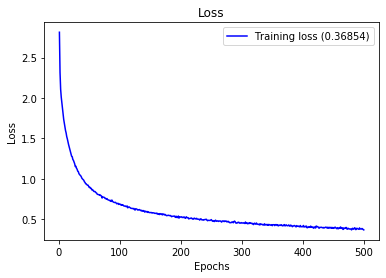

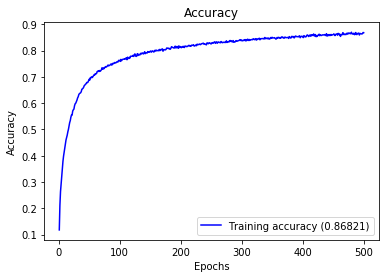

Model finished. Access the model with the .estimator attribute.
Model prediction accuracies, using all data:
Walking score: --------------------------------- 0.9889850616455078
Jogging score: --------------------------------- 0.9779300093650818
Stairs score: ---------------------------------- 0.9601694941520691
Sitting score: --------------------------------- 0.934283435344696
Standing score: -------------------------------- 0.9618082642555237
Typing score: ---------------------------------- 0.9601694941520691
Brushing teeth score: -------------------------- 0.9695788025856018
Eating soup score: ----------------------------- 0.9025558829307556
Eating chips score: ---------------------------- 0.8891585469245911
Eating pasta score: ---------------------------- 0.8541136384010315
Drinking from a cup score: --------------------- 0.890839695930481
Eating sandwich score: ------------------------- 0.9516907930374146
Kicking (soccer ball) score: ------------------- 0.9849931597709656
Playing c

In [5]:
finalmodel = Model(df)
finalmodel.preprocess(attributes, label, testsize)
finalmodel.finaltrain() # Use train/test split for training instead of kfold
finalmodel.evaluate()
final = model.estimator # this is our final saved model that is trained on all of the data

#### Evaluate model with 4-fold validation

In [6]:
model2 = Model(df)
model2.preprocess(attributes, label, testsize)

# use 4-fold validation (kfold method), which is basically averaging 4 seperate 75/25 split prediction scores
model2.train(kfold=True) 

model2.evaluate() 
# .evaluate() doesn't work with kfold=True because kfold might not properly prepare
# model2.estimator for scoring. I'm not sure which kfold it would use for scoring, or maybe a combo? Should try
# and implement kfolding manually.

estimator2 = model.estimator

Using K-fold validation method to train model and calculate score
Baseline: 81.82% (0.77%)
588.8869280815125 seconds
Model evaluation is not supported for kfold-trained data. Try using .train(kfold=False) first.
